Covid 19 감정분석 팀 : 정주은 팀장, 양진욱 팀원, 배수현 팀원

In [ ]:
# 모듈 가져오기 

import pandas as pd
import numpy as np
import re       
import nltk 

# 머신러닝 기법 활용 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

In [ ]:
# 딥러닝 기법 활용 모듈 가져오기 

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns 


from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from sklearn.metrics import classification_report


import warnings
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
# 데이터 셋 분리 (train, test)
train=pd.read_csv("gdrive/MyDrive/kaggle/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("gdrive/MyDrive/kaggle/Corona_NLP_test.csv",encoding='latin1')

In [ ]:
train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)   # str 문자형으로 변환 

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)      # str 문자형으로 변환

# 등급화 : 3단계 
# 데이터를 3개 등급(class)으로 분류 '  

# Convert sentiment into Positive = 2 , Neutral = 1 , Negative =  0
def classes_def(sentiment):
    if sentiment == "Extremely Positive":
        return "2"
    elif sentiment == "Extremely Negative":
        return "0"
    elif sentiment == "Positive":
        return "2"
    elif sentiment == "Negative":
        return "0"
    else:
        return "1"

train['label']=train['Sentiment'].apply(lambda x:classes_def(x))
test['label']=test['Sentiment'].apply(lambda x:classes_def(x))


train.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

In [ ]:
# null 값 확인 (모델 구축 위한 train 데이터 구조 확인) 
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
text                0
label               0
dtype: int64

In [ ]:
# 전체 구조 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
 6   text           41157 non-null  object
 7   label          41157 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.5+ MB


In [ ]:
# 감정분석 확인
train.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
# 감정분석 함수 적용 
train.Sentiment = train.Sentiment.apply(lambda x : classes_def(x))

2    18046
0    15398
1     7713
Name: Sentiment, dtype: int64
**********************************************************************


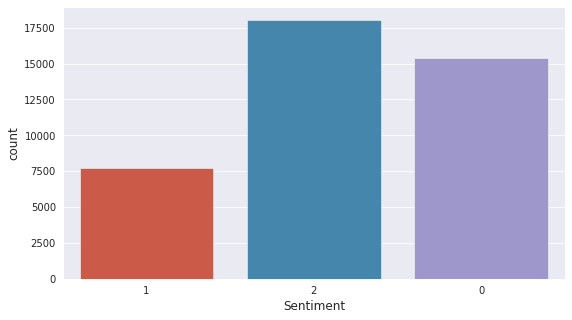

In [ ]:
# 감정분석 결과 시각화 
print(train.Sentiment.value_counts())
print('*' * 70)
plt.figure(figsize = (9,5)) 
sns.countplot(x = 'Sentiment',data = train)
plt.show()

텍스트 전처리(가공)

In [ ]:
# Urls and HTML links 제거 

def remove_url(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+') #  
    return url_remove.sub(r'', text)

train['text_new']=train['text'].apply(lambda x:remove_url(x))
test['text_new']=test['text'].apply(lambda x:remove_url(x))


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)   # 빈 칸으로 변경 

train['text']=train['text_new'].apply(lambda x:remove_html(x))
test['text']=test['text_new'].apply(lambda x:remove_html(x))

In [ ]:
# 소문자로 변경 
def lower(text):
    low_text= text.lower()
    return low_text

train['text_new']=train['text'].apply(lambda x:lower(x))
test['text_new']=test['text'].apply(lambda x:lower(x))

In [ ]:
# 숫자 제거 
def remove_num(text):
    remove= re.sub(r'\d+', '', text)  # 
    return remove

train['text']=train['text_new'].apply(lambda x:remove_num(x))
test['text']=test['text_new'].apply(lambda x:remove_num(x))

In [ ]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 불용어(stopwords)와 구두점(puncutations) 제거 

# 불용어(영어) 사전 구축
from nltk.corpus import stopwords


", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

# 구두점 제거 함수 생성
def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)  # 
    return punct

train['text_new']=train['text'].apply(lambda x:punct_remove(x))
test['text_new']=test['text'].apply(lambda x:punct_remove(x))


# 불용어 제거 함수 생성
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    # 불용어 사전에 없는 경우, 문자화한 text를 분리한 것에서 단어를 반복하여 추출 >> 리스트로 만들어 줌 

train['text']=train['text_new'].apply(lambda x:remove_stopwords(x))
test['text']=test['text_new'].apply(lambda x:remove_stopwords(x))


In [ ]:
# mentions and 해시태그(hashtags) 제거 
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text

train['text_new']=train['text'].apply(lambda x:remove_mention(x))
test['text_new']=test['text'].apply(lambda x:remove_mention(x))

In [ ]:
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text

train['text']=train['text_new'].apply(lambda x:remove_hash(x))
test['text']=test['text_new'].apply(lambda x:remove_hash(x))

In [ ]:
# 전처리 후, 공백 제거 
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
    
train['text_new']=train['text'].apply(lambda x:remove_space(x))
test['text_new']=test['text'].apply(lambda x:remove_space(x))
test = test.drop(columns=['text_new'])
train = train.drop(columns=['text_new'])

In [ ]:
# 이모지(emoji) 제거 


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

In [ ]:
stop_words = ['a', 'an', 'the']

# Basic cleansing
def cleansing(text):
    # Tokenize
    tokens = text.split(' ')
    # Lower case
    tokens = [w.lower() for w in tokens]
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# All-in-one preproce
def preprocess_x(x):
    processed_x = [cleansing(text) for text in x]
    
    return processed_x

train['text_new']=train['text'].apply(lambda x:preprocess_x(x))
test['text_new']=test['text'].apply(lambda x:preprocess_x(x))

In [ ]:
# 불용어 추가 
stop_words = ['a', 'an', 'the']

# Basic cleansing
def cleansing(text):
    # Tokenize
    tokens = text.split(' ')
    # Lower case
    tokens = [w.lower() for w in tokens]
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# All-in-one preproce
def preprocess_x(x):
    processed_x = [cleansing(text) for text in x]
    
    return processed_x

train['text_new']=train['text'].apply(lambda x:preprocess_x(x))
test['text_new']=test['text'].apply(lambda x:preprocess_x(x))

In [ ]:
# df 생성 (train 뒤에 test 붙이기)
df = train.append(test, ignore_index=True)
df.head()  

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,label,text_new
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,menyrbie phil_gahan chrisitv,1,"[m, e, n, y, r, b, i, e, , p, h, i, l, _, g, ..."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...,2,"[, d, v, i, c, e, , t, , l, k, , n, e, i, g,..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...,2,"[c, o, r, o, n, , v, i, r, u, s, , , u, s, t,..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2,food stock one empty please dont panic enough ...,2,"[f, o, o, d, , s, t, o, c, k, , o, n, e, , ..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket covid outbreak im paranoi...,0,"[r, e, , d, y, , g, o, , s, u, p, e, r, m, ,..."


In [ ]:
#  OriginalTweet 에 함수 적용 
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_url(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_html(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_hash(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_num(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_emoji(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : punct_remove(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_stopwords(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_mention(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : char(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : cleansing(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : preprocess_x(x))



In [ ]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,label,text_new
0,3799,48751,London,16-03-2020,"[m, e, n, y, r, b, i, e, , p, h, i, l, , g, ...",1,menyrbie phil_gahan chrisitv,1,"[m, e, n, y, r, b, i, e, , p, h, i, l, _, g, ..."
1,3800,48752,UK,16-03-2020,"[, d, v, i, c, e, , t, , l, k, , n, e, i, g,...",2,advice talk neighbours family exchange phone n...,2,"[, d, v, i, c, e, , t, , l, k, , n, e, i, g,..."
2,3801,48753,Vagabonds,16-03-2020,"[c, o, r, o, n, , v, i, r, u, s, , , u, s, t,...",2,coronavirus australia woolworths give elderly ...,2,"[c, o, r, o, n, , v, i, r, u, s, , , u, s, t,..."
3,3802,48754,NaN,16-03-2020,"[f, o, o, d, , s, t, o, c, k, , o, n, e, , ...",2,food stock one empty please dont panic enough ...,2,"[f, o, o, d, , s, t, o, c, k, , o, n, e, , ..."
4,3803,48755,NaN,16-03-2020,"[r, e, , d, y, , g, o, , s, u, p, e, r, m, ,...",0,ready go supermarket covid outbreak im paranoi...,0,"[r, e, , d, y, , g, o, , s, u, p, e, r, m, ,..."
...,...,...,...,...,...,...,...,...,...
44950,3794,48746,Israel ??,16-03-2020,"[m, e, , n, w, h, i, l, e, , s, u, p, e, r, m...",Positive,meanwhile supermarket israel people dance sing...,2,"[m, e, , n, w, h, i, l, e, , s, u, p, e, r, m..."
44951,3795,48747,"Farmington, NM",16-03-2020,"[p, , n, i, c, , b, u, y, , l, o, t, , n, o...",Negative,panic buy lot nonperishable items echo needs f...,0,"[p, , n, i, c, , b, u, y, , l, o, t, , n, o..."
44952,3796,48748,"Haverford, PA",16-03-2020,"[, s, s, t, , p, r, o, f, , e, c, o, n, o, m...",Neutral,asst prof economics cconces nbcphiladelphia ta...,1,"[, s, s, t, , p, r, o, f, , e, c, o, n, o, m..."
44953,3797,48749,NaN,16-03-2020,"[g, o, v, , n, e, e, d, , s, o, m, e, t, h, ...",Extremely Negative,gov need somethings instead biar je rakyat ass...,0,"[g, o, v, , n, e, e, d, , s, o, m, e, t, h, ..."


In [ ]:
# 데이터셋 분리(X,y) 후, 리스트로 만들어 주기 

X = train["text"].tolist()      
y = train["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10,  
                                                    random_state = 0)

In [ ]:
# tf-idf 적용 

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                    
                        stop_words='english')

# 텍스트를 벡터로 만들어 주기 
features = tfidf.fit_transform(train.text).toarray()   # 배열로 변경 

labels = train.label

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 41157 tweets is represented by 10615 features (TF-IDF score of unigrams and bigrams)


In [ ]:
# 머신러닝 기법 중, 랜덤 포레스트, 선형 SVC, Multinomial 나이브베이즈 적용 

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 개의 교차 분석 실시(Cross-validation_)
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.474976
1,RandomForestClassifier,1,0.469631
2,RandomForestClassifier,2,0.472118
3,RandomForestClassifier,3,0.467987
4,RandomForestClassifier,4,0.465436
5,LinearSVC,0,0.782070
6,LinearSVC,1,0.780855
7,LinearSVC,2,0.780464
8,LinearSVC,3,0.789333
9,LinearSVC,4,0.789333


In [ ]:
# 교차 분석 평균 값(평균 정확도, 표준편차 정확도 구하기)
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.784411,0.004532
MultinomialNB,0.659791,0.003452
RandomForestClassifier,0.470029,0.003683


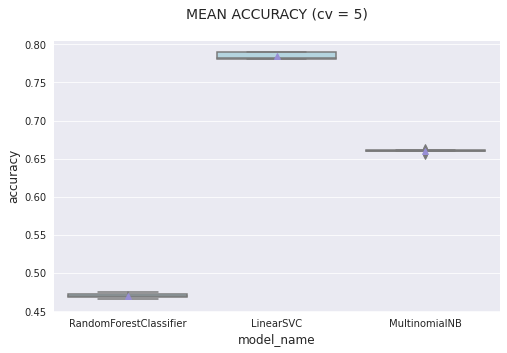

In [ ]:
# 결과 시각화 하기 

plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train.index, test_size=0.10, 
                                                               random_state=1)
model =   LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
# Classification report

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train['label'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.80      0.79      0.80      1554
           2       0.69      0.67      0.68       760
           0       0.82      0.84      0.83      1802

    accuracy                           0.79      4116
   macro avg       0.77      0.77      0.77      4116
weighted avg       0.79      0.79      0.79      4116



결과 해석

1. 분석 결과, LinearSVC (서포트벡터머신) 결과가 0.784411 가장 우수
2. 랜덤포레스트 결과가 기대 이하로 나타남(0.470029) 
3. LinearSVC로 Confusion Matrix로 확인 결과, 정확도(acc) 79% 임
4. f1-score(recall과 precision을 조화평균한 값)이 1('Neutral'),0('Negative') 는 0.80, 0.83으로 분류된 반면, 2('Positive')는 0.68로 성능이 상당히 떨어지는 것으로 나타남 

>> 결론 : 이에 딥러닝 기법인 LSTM으로 추가 분석을 실시하고자 함



In [ ]:
train['label']

0        1
1        2
2        2
3        2
4        0
        ..
41152    1
41153    0
41154    2
41155    1
41156    0
Name: label, Length: 41157, dtype: object

In [ ]:
test['label']

0       0
1       2
2       2
3       0
4       1
       ..
3793    2
3794    0
3795    1
3796    0
3797    2
Name: label, Length: 3798, dtype: object

In [ ]:
df['label']

0        1
1        2
2        2
3        2
4        0
        ..
44950    2
44951    0
44952    1
44953    0
44954    2
Name: label, Length: 44955, dtype: object

딥러닝 기법 모델 적용(LSTM)

In [ ]:
# 데이터 셋 분리 (train, test)
train=pd.read_csv("gdrive/MyDrive/kaggle/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("gdrive/MyDrive/kaggle/Corona_NLP_test.csv",encoding='latin1')

In [ ]:
# train data와 test data 를 합쳐서 재분류 실시 (무작위, 확률추출하기 위함)
df = train.append(test, ignore_index=True)

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# null 값 확인
df.isnull().sum()  

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [ ]:
# 전체 데이터구조 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


In [ ]:
# 새로 생성된 df에 classes_def 적용
df.Sentiment = df.Sentiment.apply(lambda x : classes_def(x))


2    19592
0    17031
1     8332
Name: Sentiment, dtype: int64
**********************************************************************


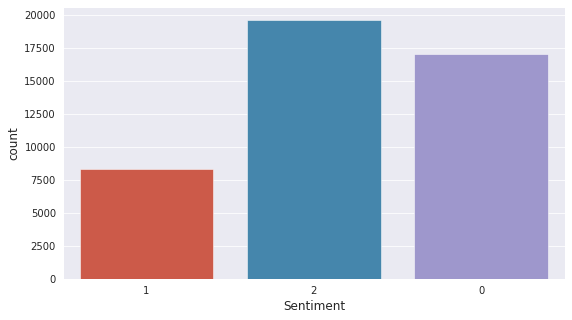

In [ ]:
# 감정분석 시각화
print(df.Sentiment.value_counts())
print('*' * 70)
plt.figure(figsize = (9,5)) 
sns.countplot(x = 'Sentiment',data = df)
plt.show()

In [ ]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_url(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_emoji(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : decontraction(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : char(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())

- \S : 공백 아님
- [^ ] : 반대 
- \w: 숫자나 문자
- \s : 공백
- \d : 숫자
- + : 최소 한 번 이상 반복
- ? : 앞에 있는 문자가 없거나 하나 있을 때
- | : 여러 개의 표현식 중 하나 (or)


- http:// 또는 https://로 시작하는 공백없는 문자 혹은 www.로 시작하는 공백 없는 문자 제거
- 최소 한 번 이상 반복되는 숫자 제거
- 문자나 공백이나 숫자가 아니면 제거(구두점 제거)
- @로 시작하는 문자나 숫자 제거(멘션 제거)
- #로 시작하는 문자나 숫자 제거(해시태그 제거)
- 공백이 반복되면 제거

In [ ]:
# Split sentiment groups 
Positive = df[df['Sentiment'] == 2].OriginalTweet
Neutral  = df[df['Sentiment'] == 1].OriginalTweet
Negative = df[df['Sentiment'] == 0].OriginalTweet

In [ ]:
!pip install wordcloud

In [ ]:
!pip install matplotlib-venn

In [ ]:
from wordcloud import WordCloud

In [ ]:
X = df['OriginalTweet']
y = df['Sentiment']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (35964,)
Shape of y_train :  (35964,)
Shape of X_test :  (8991,)
Shape of y_test :  (8991,)


In [ ]:
X

0                     menyrbie phil gahan chrisitv and and
1        advice talk to your neighbours family to excha...
2        coronavirus australia woolworths to give elder...
3        my food stock is not the only one which is emp...
4        me ready to go at supermarket during the covid...
                               ...                        
44950    meanwhile in a supermarket in israel people da...
44951    did you panic buy a lot of non perishable item...
44952    asst prof of economics cconces was on nbcphila...
44953    gov need to do somethings instead of biar je r...
44954    i and forestandpaper members are committed to ...
Name: OriginalTweet, Length: 44955, dtype: object

In [ ]:
y

0        1
1        2
2        2
3        2
4        0
        ..
44950    2
44951    0
44952    1
44953    0
44954    2
Name: Sentiment, Length: 44955, dtype: object

In [ ]:
# Split sentiment groups 
Positive = df[df['Sentiment'] == 2].OriginalTweet
Neutral  = df[df['Sentiment'] == 1].OriginalTweet
Negative = df[df['Sentiment'] == 0].OriginalTweet


In [ ]:
# Convert y to categorical (범주형 데이터로 변경)
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)

In [ ]:
# 토큰화(Tokenize Texts) 
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# 토큰화된 텍스트를 패딩 사이즈 맞추어 주기 convert tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
# 모델링 (LSTM)
inp = Input(shape=(maxlen, )) 
x   =  Embedding(max_features, embed_size)(inp)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)    # MaxPoolking1D  사용 
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(3, activation="softmax")(x)   # 다중 분류 위해 softmax 사용 

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',  # one-hot encoding 되었기 때문, categorical_crossentropy 사용
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# 모델 최적화 실행
model.fit(X_train_final,y_train, epochs=2,validation_data=(X_test_final,y_test))

Epoch 1/2
1124/1124 [==============================] - 56s 48ms/step - loss: 0.6038 - accuracy: 0.7513 - val_loss: 0.4033 - val_accuracy: 0.8626
Epoch 2/2
1124/1124 [==============================] - 53s 47ms/step - loss: 0.3048 - accuracy: 0.8998 - val_loss: 0.3669 - val_accuracy: 0.8725


In [ ]:
# 모델 평가(test data 활용) 
model.evaluate(X_test_final,y_test)

281/281 [==============================] - 5s 17ms/step - loss: 0.3669 - accuracy: 0.8725


[0.3668677508831024, 0.872539222240448]

In [ ]:
# 모델 예측 확인
lstm_pred = np.round(model.predict(X_test_final))

In [ ]:
# confusion matrix로 분류 결과 확인 
# Precision , Recall , F1-score
cr = classification_report(y_test,lstm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3466
           1       0.91      0.78      0.84      1683
           2       0.89      0.88      0.88      3842

   micro avg       0.88      0.86      0.87      8991
   macro avg       0.89      0.85      0.87      8991
weighted avg       0.89      0.86      0.87      8991
 samples avg       0.86      0.86      0.86      8991



최종 결과 해석 

1. 모델 성능 개선을 위해 LSTM 적용함
2. 분석 결과, 정확도(acc) 는 87% 으로 나타남
3. 혼동행렬으로 분류 분석 결과, f-1 score는 87% 으로 성능 개선된 것으로 확인됨
4. 향후 계획은 bert를 활용, 추가 성능 개선을 모색하고자 함   

